In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture
from sklearn import mixture
import datetime as dt
import itertools

In [3]:
# Data snapshot from 3/11/2022
# https://donnees.montreal.ca/ville-de-montreal/actes-criminels
data = pd.read_csv("data/montreal_crime_data.csv", encoding='latin1')

In [4]:
data.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,-76.237290,0.000000
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,-76.237290,0.000000


## Preprocessing & exploring

In [5]:
data.columns

Index(['CATEGORIE', 'DATE', 'QUART', 'PDQ', 'X', 'Y', 'LONGITUDE', 'LATITUDE'], dtype='object')

#### Meta information of data

In [6]:
print(f"Shape of data is: {data.shape}")

Shape of data is: (214322, 8)


In [7]:
pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')

,Datatype
Columns,
CATEGORIE,object
DATE,object
QUART,object
PDQ,float64
X,float64
Y,float64
LONGITUDE,float64
LATITUDE,float64


## Data cleaning

#### Converting date feature to datatime format

In [8]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [9]:
data['DATE'].head()

0   2018-09-13
1   2018-04-30
2   2018-09-01
3   2017-07-21
4   2017-07-29
Name: DATE, dtype: datetime64[ns]

In [10]:
datatypes = pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
datatypes

,Datatype
Columns,
CATEGORIE,object
DATE,datetime64[ns]
QUART,object
PDQ,float64
X,float64
Y,float64
LONGITUDE,float64
LATITUDE,float64


#### Checking for NaN values

In [11]:
pd.DataFrame(data.isnull().sum(), columns=['Nb of missing values']).rename_axis('Feature')

,Nb of missing values
Feature,
CATEGORIE,0
DATE,0
QUART,0
PDQ,5
X,0
Y,0
LONGITUDE,0
LATITUDE,0


## Modélization

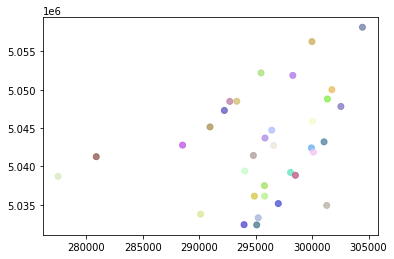

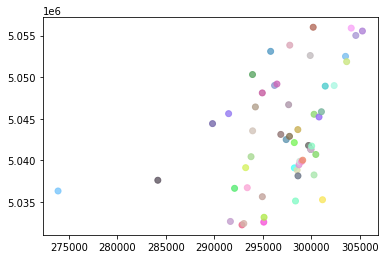

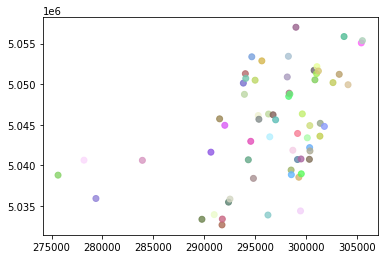

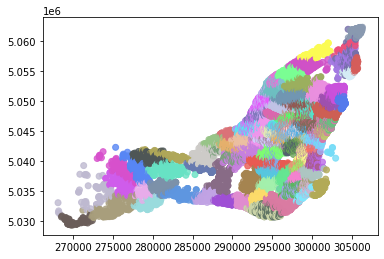

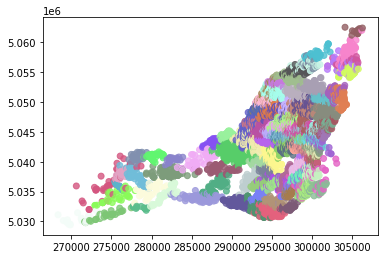

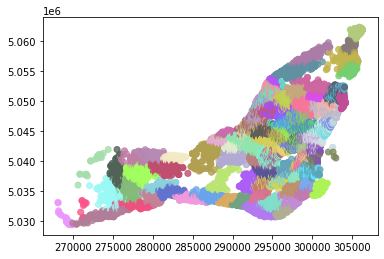

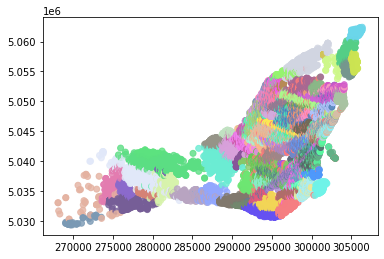

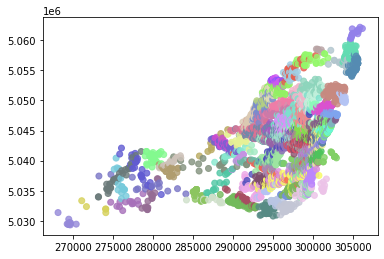

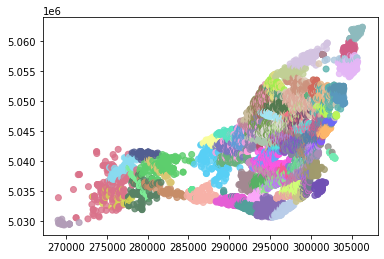

In [ ]:
for category in np.unique(data.CATEGORIE):
    for quart in np.unique(category_data.QUART):
        cat = (data.CATEGORIE == category)
        qrt = (data.QUART == quart)
        pgx = (data.X > 1000)
        plx = (data.X < 1e6)
        pgy = (data.Y > 1000)
        split_data = data[cat*qrt*pgx*plx*pgy]
        #print(split_data)
        #print(len(split_data.index))
        
        mindate = data.DATE.min()
        def timetofloat(d):
            deltas = (d - mindate)  / np.timedelta64(1,'D')
            return deltas
        coords = np.vstack((split_data.X, split_data.Y, timetofloat(split_data.DATE))).T
        #coords.sort()
        coords = np.unique([tuple(row) for row in coords], axis=0)
        #print(coords)
        #print(len(coords))
        
        ncomponents = min(100,len(coords))
        classifier = GaussianMixture(n_components=ncomponents, covariance_type="full")
        
        #plt.scatter(coords[:,0],y=coords[:,1])
        #plt.show
        #plt.clf()
        #plt.cla()
        #plt.close()
        
        classifier.fit(coords)
        
        maxdatef = timetofloat(data.DATE.max())
        testdata = np.array([[ 294904, 5047548, maxdatef],
                            [ 294904, 5047548, maxdatef],
                            [ 290274, 5042150, maxdatef],
                            [ 299344, 5040364, maxdatef],
                            [ 294968, 5047651, maxdatef],
                            [ 291553, 5035569, maxdatef]])
        
        #print(classifier.means_)

        colors = []
        for i in range(ncomponents):
            colors.append(tuple(np.random.uniform(0.3, 1, size=3)))
    
        #dcolors = [colors[i] for i in classifier.predict(testdata)]
        dcolors = [colors[i] for i in classifier.predict(coords)]


        #ax = plt.gca()
        plt.clf()
        plt.cla()
        plt.close()
        #plt.scatter(testdata[:,0], testdata[:,1], c=dcolors, alpha=0.8)
        plt.scatter(coords[:,0], coords[:,1], c=dcolors, alpha=0.8)
        plt.show()

In [47]:
classifier = GaussianMixture(n_components=100, covariance_type="full")

In [48]:
coords = np.vstack((data.X, data.Y)).T

In [49]:
filtereddata = np.array(list(filter(lambda d: ((d[0] > 1000 and d[1] > 1000) and (d[0] < 1e6)), coords)))
filtereddata[:,0]

array([294904.15900121, 294904.15900121, 290274.565     , ...,
       299344.83600734, 294968.04999209, 291553.78100532])

NameError: name 'filtereddata' is not defined

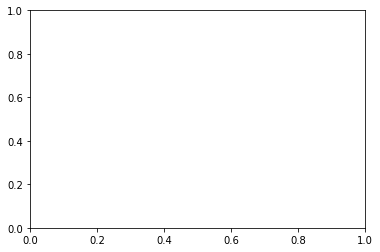

In [51]:
plt.scatter(filtereddata[:,0],y=filtereddata[:,1])
plt.show

In [51]:
classifier.fit(filtereddata)

GaussianMixture(n_components=100)

In [52]:
testdata = np.array([[ 294904, 5047548],
       [ 294904, 5047548],
       [ 290274, 5042150],
       [ 299344, 5040364],
       [ 294968, 5047651],
       [ 291553, 5035569]])

[[ 300424.68117532 5042652.50757901]
 [ 287325.02643011 5035301.03924922]
 [ 296628.86819725 5050407.46245575]
 [ 295129.61531418 5032888.11699866]
 [ 303106.55248594 5052000.16683301]
 [ 275821.21803553 5037364.99110731]
 [ 293967.46403845 5044905.36909577]
 [ 296567.10793832 5037294.66767886]
 [ 287769.87326443 5043152.67424298]
 [ 297703.50707823 5044905.77815976]
 [ 298544.55235135 5039270.65203245]
 [ 301661.37964327 5048560.54851212]
 [ 300246.8327077  5057660.12660425]
 [ 272718.472455   5031313.86265183]
 [ 304969.2636895  5054922.08552919]
 [ 290548.47135316 5033493.72088793]
 [ 295497.68441806 5052965.99775171]
 [ 298208.05846804 5037495.08406517]
 [ 282674.16570441 5040183.83143003]
 [ 279783.09380778 5034189.318596  ]
 [ 289048.65050369 5039590.69018353]
 [ 301928.7487693  5045638.09698508]
 [ 295148.41593057 5047737.15604767]
 [ 299763.91885786 5049017.92121665]
 [ 294833.76293831 5040764.79120466]
 [ 297630.49699085 5042557.9276462 ]
 [ 304211.81146436 5058119.58865573]
 

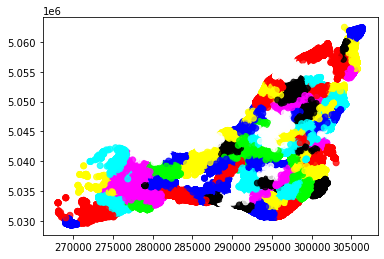

In [53]:
print(classifier.means_)

colors = []
for i in range(100):
    colors.append(tuple(np.random.choice(range(0, 2), size=3)))
    
dcolors = [colors[i] for i in classifier.predict(filtereddata)]

ax = plt.gca()
ax.scatter(filtereddata[:,0], filtereddata[:,1], c=dcolors, alpha=0.8)
plt.show()

In [37]:
def fit_samples(samples):
    gmix = GaussianMixture(n_components=100, covariance_type='spherical')
    gmix.fit(samples)
    print(gmix.means_)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in gmix.predict(samples)]
    ax = plt.gca()
    ax.scatter(samples[:,0], samples[:,1], alpha=0.8)
    plt.show()

[[ 293921.03597123 5035240.71361141]
 [ 298401.07816008 5052023.62211517]
 [ 299298.45925569 5045350.08365158]
 [ 278392.43910645 5040374.28011334]
 [ 291823.66614316 5045296.31498375]
 [ 300155.391782   5040607.81096696]
 [ 296985.01481999 5050792.92900468]
 [ 304093.03972655 5056863.59939038]
 [ 301660.75520979 5048454.82229122]
 [ 278410.03045741 5037874.47808383]
 [ 285536.33750813 5039278.33376386]
 [ 291407.9247519  5041562.68550945]
 [ 298979.81559767 5041992.24614749]
 [ 301104.65109904 5035634.93183228]
 [ 294327.55099772 5045170.33577507]
 [ 293975.5431004  5049682.50726565]
 [ 289730.60588664 5033335.59866558]
 [ 273104.14921843 5031399.72407505]
 [ 301371.12271727 5045000.31381883]
 [ 281687.78488276 5038278.19533597]
 [ 297327.99318489 5034945.41798   ]
 [ 296759.53776813 5043893.17599153]
 [ 296865.76877612 5046968.57789977]
 [ 295194.86862614 5039713.4061696 ]
 [ 298337.40231659 5038787.04452491]
 [ 295170.69244445 5033077.56162095]
 [ 285524.6549023  5034329.20967948]
 

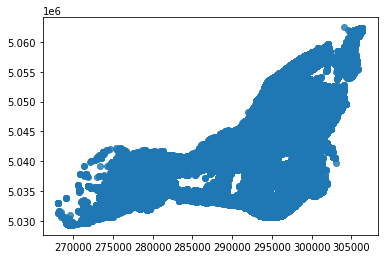

In [38]:
fit_samples(filtereddata)

## Visualization